In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from tensorflow import keras
from keras import layers
import shutil
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import os

import pandas as pd
from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn import metrics

import cv2
import gc
import time
from PIL import Image

In [4]:
model = tf.keras.models.load_model('cnn_model.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 43, 43, 64)       

In [5]:
EPSILON = 0.05  # Maximum allowed perturbation
MAX_ITERS = 10  # Number of iterations to generate UAP
BATCH_SIZE = 32  # Same batch size as your training
IMG_SIZE = 180  # Image size (adjust if needed)

In [7]:
def generate_uap(model, dataset, epsilon=EPSILON, max_iters=MAX_ITERS):
    uap = tf.Variable(tf.zeros((IMG_SIZE, IMG_SIZE, 3)), trainable=True, dtype=tf.float32)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

    for _ in range(max_iters):
        for image_batch, label_batch in tqdm(dataset):
            with tf.GradientTape() as tape:
                # Add the perturbation to the batch of images
                perturbed_images = tf.clip_by_value(image_batch + uap, 0.0, 1.0)
                predictions = model(perturbed_images)

                # Compute loss (maximize the loss of correct predictions)
                loss = -tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(label_batch, predictions))

            # Compute gradients and update UAP
            gradients = tape.gradient(loss, uap)
            optimizer.apply_gradients([(gradients, uap)])

            # Project UAP to epsilon-ball
            uap.assign(tf.clip_by_value(uap, -epsilon, epsilon))

    return uap

In [8]:
#save_dir = "/home/mandal.n/VML/Project/Data/adversarial_attacked_images"
#os.makedirs(save_dir, exist_ok=True)

In [9]:
path = '/home/mandal.n/VML/Project/Data/image_sets'
classes = [folder for folder in os.listdir(path) if folder != '.ipynb_checkpoints']
#classes = os.listdir(path)
classes

['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']

In [10]:
dirpath='/home/mandal.n/VML/Project/Data/image_sets'
#dirpath=[folder for folder in os.listdir(path) if folder != '.ipynb_checkpoints']
IMG_SIZE=180
BATCH_SIZE=32
CHANNELS=3
EPOCHS=20
INPUT_SHAPE = (BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNELS)
N_CLASSES = 5

In [13]:
original_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dirpath,
    seed=123,
    shuffle=True,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

class_names = original_dataset.class_names  # Save class names

dataset = original_dataset.map(lambda x, y: (x / 255.0, y)) \
                          .cache() \
                          .shuffle(1000) \
                          .prefetch(buffer_size=tf.data.AUTOTUNE)



Found 25000 files belonging to 5 classes.


In [14]:
def split_train_val_test(dataset,train_split=0.8,test_split=0.1,val_split=0.1,shuffle=True,shuffle_size=10000):
   assert(train_split+val_split+test_split)==1


   if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)
    #set size of train,test and val
   train_size=int(train_split*len(dataset))
   val_size=int(val_split*len(dataset))
   test_size=int(test_split*len(dataset))


   train_ds=dataset.take(train_size)
   val_ds=dataset.skip(train_size).take(val_size)
   test_ds=dataset.skip(train_size+val_size).take(test_size)


   return train_ds,val_ds,test_ds

In [15]:
train,val,test=split_train_val_test(dataset)

In [16]:
train_ds = train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (x / 255.0, y)) \
                 .cache() \
                 .shuffle(1000) \
                 .prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
resize_scaling=tf.keras.Sequential([
    layers.Resizing(IMG_SIZE,IMG_SIZE),
    layers.Rescaling(1./255)
])

In [18]:
uap = generate_uap(model, test_ds, epsilon=EPSILON, max_iters=MAX_ITERS)

100%|██████████| 78/78 [01:13<00:00,  1.06it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


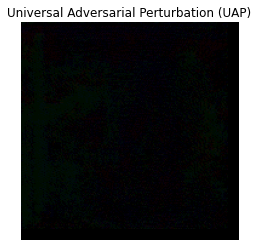

In [19]:
plt.imshow(uap.numpy())
plt.title("Universal Adversarial Perturbation (UAP)")
plt.axis('off')
plt.show()

In [20]:
def evaluate_with_uap(model, dataset, uap):
    total = 0
    correct = 0

    for image_batch, label_batch in tqdm(dataset):
        # Add UAP to images
        perturbed_images = tf.clip_by_value(image_batch + uap, 0.0, 1.0)
        predictions = model(perturbed_images)
        predicted_labels = tf.argmax(predictions, axis=1)

        # Cast both label_batch and predicted_labels to int64
        label_batch = tf.cast(label_batch, tf.int64)
        predicted_labels = tf.cast(predicted_labels, tf.int64)

        # Compute accuracy
        total += label_batch.shape[0]
        correct += tf.reduce_sum(tf.cast(predicted_labels == label_batch, tf.int32))

    accuracy = correct / total * 100
    print(f"Accuracy under UAP: {accuracy:.2f}%")


In [21]:
evaluate_with_uap(model, test_ds, uap)

100%|██████████| 78/78 [00:16<00:00,  4.76it/s]

Accuracy under UAP: 19.99%


In [22]:
def scale_for_visualization(images):
    if tf.reduce_max(images) > 1.0:  
        return images / 255.0
    return images


In [23]:
def visualize_attacked_images(model, dataset, uap, class_names, num_images=5):
    """
    Visualize original and attacked images with debugging and scaling for visualization.

    Args:
        model: Trained Keras model.
        dataset: Test dataset.
        uap: Universal Adversarial Perturbation.
        class_names: List of class names.
        num_images: Number of images to visualize.
    """
    # Debug UAP Pixel Values
    print("Debug - UAP Pixel Range:")
    print(f"Min: {tf.reduce_min(uap).numpy()}, Max: {tf.reduce_max(uap).numpy()}")
    
    # Normalize UAP for visualization
    uap_visual = (uap.numpy() - tf.reduce_min(uap.numpy())) / (tf.reduce_max(uap.numpy()) - tf.reduce_min(uap.numpy()))
    plt.imshow(uap_visual)
    plt.title("Universal Adversarial Perturbation (UAP)")
    plt.axis("off")
    plt.show()

    # Process dataset
    for image_batch, label_batch in dataset.take(1):
        # Debug Original Image Batch Pixel Range
        print("Debug - Original Image Batch Pixel Range:")
        print(f"Min: {tf.reduce_min(image_batch).numpy()}, Max: {tf.reduce_max(image_batch).numpy()}")

        # Apply UAP and scale for visualization
        perturbed_images = tf.clip_by_value(image_batch + uap, 0.0, 1.0)
        scaled_images = scale_for_visualization(image_batch)
        scaled_perturbed_images = scale_for_visualization(perturbed_images)

        # Debug Perturbed Image Pixel Range
        print("Debug - Perturbed Image Pixel Range:")
        print(f"Min: {tf.reduce_min(perturbed_images).numpy()}, Max: {tf.reduce_max(perturbed_images).numpy()}")

        # Model predictions
        predictions = model(perturbed_images)
        predicted_labels = tf.argmax(predictions, axis=1)

        plt.figure(figsize=(15, 10))
        for i in range(num_images):
            plt.subplot(2, num_images, i + 1)
            plt.imshow(scaled_images[i].numpy())
            plt.title(f"Original")
            plt.axis("off")

            plt.subplot(2, num_images, num_images + i + 1)
            plt.imshow(scaled_perturbed_images[i].numpy())
            plt.title(f"Attacked")
            plt.axis("off")

        plt.tight_layout()
        plt.show()
        break


Debug - UAP Pixel Range:
Min: -0.05000000074505806, Max: 0.05000000074505806


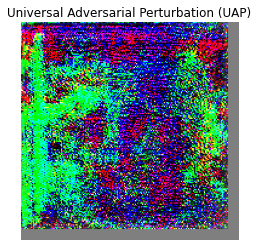

Debug - Original Image Batch Pixel Range:
Min: 0.0, Max: 1.0
Debug - Perturbed Image Pixel Range:
Min: 0.0, Max: 1.0


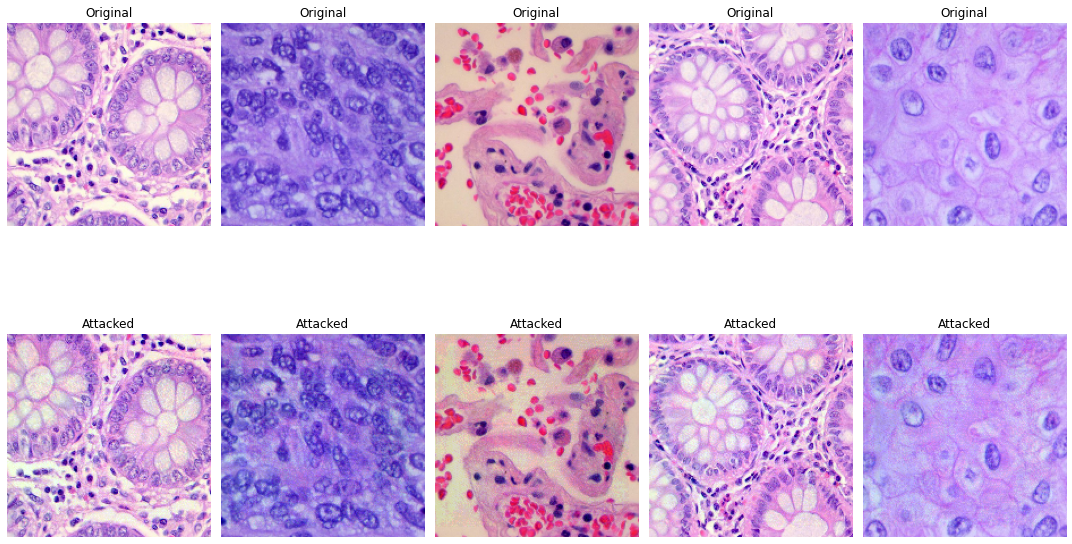

In [24]:
visualize_attacked_images(model, test, uap, class_names, num_images=5)

In [50]:
def save_visualized_attacked_images(model, dataset, uap, class_names, save_dir, num_images=5):
    """
    Save original and attacked images in a visually processed form.

    Args:
        model: Trained Keras model.
        dataset: Dataset to attack.
        uap: Universal Adversarial Perturbation.
        class_names: List of class names.
        save_dir: Directory to save the attacked images.
        num_images: Number of images to save for each batch.
    """
    # Ensure save directory exists
    os.makedirs(save_dir, exist_ok=True)

    print(f"Saving visualized attacked dataset to {save_dir}...")

    count = 0  # Counter for filenames

    for image_batch, label_batch in tqdm(dataset):
        # Apply UAP and scale for saving
        perturbed_images = tf.clip_by_value(image_batch + uap, 0.0, 1.0)
        scaled_images = (image_batch.numpy() * 255).astype("uint8")
        scaled_perturbed_images = (perturbed_images.numpy() * 255).astype("uint8")

        # Model predictions for perturbed images
        predictions = model(perturbed_images)
        predicted_labels = tf.argmax(predictions, axis=1)

        # Save each image
        for i in range(min(num_images, image_batch.shape[0])):
            original_image = scaled_images[i]  # Properly scaled original image
            perturbed_image = scaled_perturbed_images[i]  # Properly scaled perturbed image

            true_label = class_names[label_batch[i].numpy()]
            attacked_label = class_names[predicted_labels[i].numpy()]

            # Save original image
            original_image_path = os.path.join(save_dir, f"original_{count}_{true_label}.png")
            Image.fromarray(original_image).save(original_image_path)

            # Save perturbed image
            perturbed_image_path = os.path.join(save_dir, f"attacked_{count}_{attacked_label}.png")
            Image.fromarray(perturbed_image).save(perturbed_image_path)

            count += 1

    print(f"Total images saved: {count}")
